In [76]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import urllib.request
import json
import os
import pandas as pd

import src.helpers.data_helpers as dth

# Charger les variables d'environnement depuis le ficher .env
from dotenv import load_dotenv

load_dotenv()
url = os.getenv("AZURE_API_DESIGNER_ENDPOINT")
api_key = os.getenv("AZURE_API_DESIGNER_KEY")

In [77]:
# Charger les données depuis le fichier csv
data_tweets = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data_tweets = data_tweets[["text", "target"]]


# Echantillon de 1000 tweets positifs et 1000 tweets négatifs
sample_negatif = data_tweets[data_tweets['target'] == 0].sample(n = 1000)
sample_positif = data_tweets[data_tweets['target'] == 4].sample(n = 1000)

sample = pd.concat([sample_negatif, sample_positif])

In [78]:
data =  {
  "Inputs": {
    "WebServiceInput0": []
  },
  "GlobalParameters": {}
}

In [79]:
for tweet in sample['text']:
    data['Inputs']['WebServiceInput0'].append({"Column6": tweet})

In [80]:
body = str.encode(json.dumps(data))

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

In [81]:
result_json = json.loads(result.decode('utf-8'))
result_json

{'Results': {'WebServiceOutput0': [{'Scored Labels': 0.0,
    'Scored Probabilities': 0.4691708401012928},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.3580569947140678},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.11862391163306171},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.07411548833536441},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.030071487343669465},
   {'Scored Labels': 4.0, 'Scored Probabilities': 0.5446058282323869},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.23903397475016688},
   {'Scored Labels': 4.0, 'Scored Probabilities': 0.7223715909017698},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.31913494703498535},
   {'Scored Labels': 4.0, 'Scored Probabilities': 0.888025512303355},
   {'Scored Labels': 4.0, 'Scored Probabilities': 0.6680060640378864},
   {'Scored Labels': 4.0, 'Scored Probabilities': 0.6944740586296796},
   {'Scored Labels': 0.0, 'Scored Probabilities': 0.28274099806494346},
   {'Scored Labels': 4.0, 'Scored P

In [82]:
y_pred = []
y_pred_prob = []

for r in result_json['Results']['WebServiceOutput0']:
    y_pred.append(0 if int(r['Scored Labels']) == 0 else 1)
    y_pred_prob.append(r['Scored Probabilities'])

In [83]:
sample['target'] = sample['target'].map(
    {
        0: 0,
        4: 1
    }
)

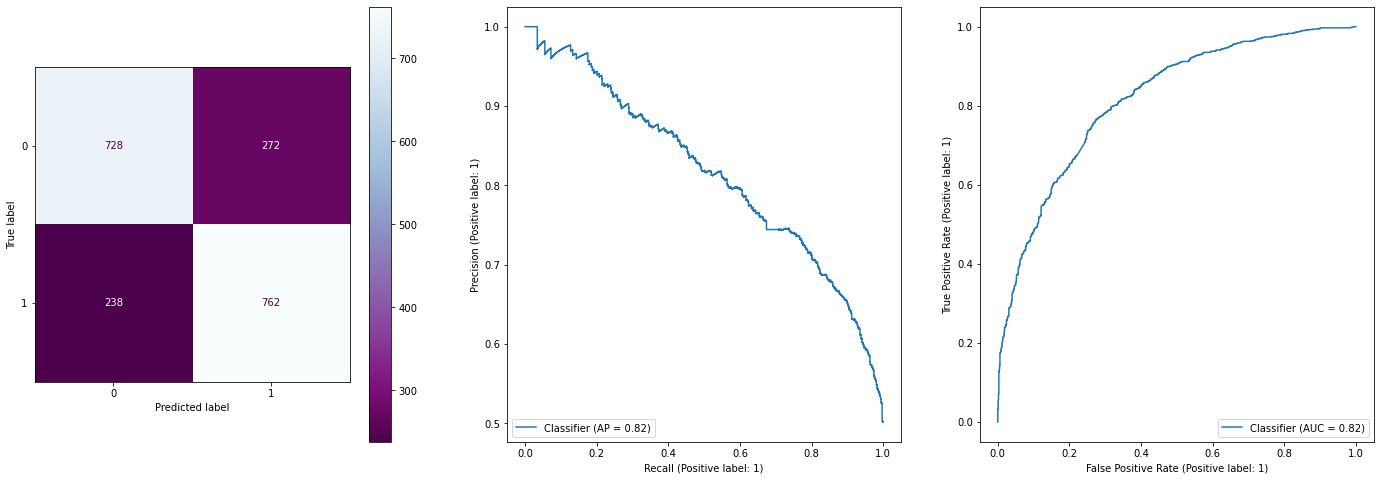

In [84]:
dth.plot_classifier_results(None, None, sample['target'], y_pred, y_pred_prob)